# Creating a plume radiance texture map

This notebook forms part of a series on [computational optical radiometry](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi).  The notebooks can be downloaded from [Github](https://github.com/NelisW/ComputationalRadiometry#computational-optical-radiometry-with-pyradi). These notebooks are constantly revised and updated, please revisit from time to time.  


[<img src="https://zenodo.org/badge/doi/10.5281/zenodo.9910.png"   align="left"/>](http://dx.doi.org/10.5281/zenodo.9910)


The date of this document and module versions used in this document are given at the end of the file.  
Feedback is appreciated: neliswillers at gmail dot com.

## Introduction

This notebook describes a method to create a radiance texture map of a CO$_\textrm{2}$ aircraft engine plume in the MWIR band, starting from a temperature profile in graph format.  In this particular case study the temperature information is shown as spatial iso-temperature lines.  Plume radiance is three dimensional physical phenomenon but for this analysis it is simplified to a two dimensional projection of the radiance.

The steps in this process are as follows:

- Scan the graph to determine the $(d,r)$ coordinates for each of the iso-temperature lines.  These coordinates are not in a regular grid.
- Interpolate the scanned temperature profiles from the scattered coordinates into a regular grid. The regular grid intervals can be set according to the user need. In this case a relatively dense grid is used to obtain an image of the plume radiance.
- Calculate the radiance for each of the pixels, using the interpolated temperature values.  The radiance is calculated using spectral CO$_\textrm{2}$ emissivity values.  Spectral emissivity shape depends on the temperature and pressure of the exhaust gas.  Accurate modelling therefore requires pressure profiles (in addition to the temperature profile), and also requires an accurate model of the spectral emissivity as function of temperature and pressure.  The radiance in each pixel is calculated using 
\begin{equation}
L(d,r) = \epsilon(T,P,d,r) L_\textrm{bb}(T)
\end{equation}
where
$\epsilon(T,Pd,r)$ is the emissivity at location $(d,r)$ at temperature $T$ and pressure $P$, and 
$L_\textrm{bb}(T)$ is the Planck-law radiance at temperature $T$.  This calculation does not attempt to calculate the emissivity from first principles, instead measured information is used to model the emissivity at different temperatures (disregarding pressure effects).  To obtain the wideband spectral radiance, the spectral radiance must then be integrated over the sensor spectral bandwidth.
\begin{equation}
L_\textrm{plume}(d,r) = \int_{\Delta\lambda}\tau_\textrm{S}\cdot\epsilon_\textrm{plume}(T_\textrm{plume},d,r)\cdot L_\textrm{bb}(T_\textrm{plume},d,r) \textrm{d} \lambda
\end{equation}
where
$\tau_\textrm{S}$ is the sensor spectral response, 
$\epsilon_\textrm{plume}(T_\textrm{plume},d,r)$ is the plume spectral emissivity at temperature $T$ in pixel $(d,r)$, and 
$L(T_\textrm{plume},d,r)$ is the Planck-law radiance at temperature $T$ pixel $(d,r)$.

- In our intended application the emissivity texture will be used on a single polygon with a single temperature.  The radiance map is then used to calculate a scaling texture map, normalised to the maximum temperature.
\begin{equation}
s(d,r) = L_\textrm{plume}(d,r) /  L_\textrm{bb}(T_\textrm{max}).
\end{equation}
Of course this an approximation, but it is sufficient for the current need.

## Set up Python environment

In [1]:
# to prepare the environment
import numpy as np
import scipy as sp
import pandas as pd
import os.path
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import integrate
from scipy import signal
from scipy import ndimage
import matplotlib.pyplot as plt
import scipy.constants as const
import pickle

import collections

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'

pim = ryplot.ProcessImage()
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 150)

## Scan the temperature profile

The temperature profile is given in the form of a few graphs of iso-temperature values, redrawn as shown below.   It is assumed that these values represent temperatures in the plume as would be measured by a thermocouple (gas temperature).  For simplicity it is assumed that the plume is rotationally symmetrical.

![plume-temp.PNG](images/plume-temp.PNG)

Digitising data from a graph is a tiresome and inherently error-prone task. Manual (eyeball) reading the values is not suited for complex graphs, such as [spectroscopy data](https://www2.chemistry.msu.edu/faculty/reusch/virttxtjml/Spectrpy/InfraRed/infrared.htm).  For this purpose an alternative method was developed to scan an image of the graph using a short Python script.  The code is quite basic and therefore the procedure requires some manual preparatory work:

1. Obtain a PNG image (JPEG may have too much noise) of the graph by scanning or screen grab (Snipping tool on Windows).
2. Correct the image by removing any warping, skewing or rotation.  The end result should present the axes of the graph in a regular rectangle.  This task can be completed by using tools such as Photoshop, PrintShopPro, Gimp, ImageMagick or similar.
3. Remove all clutter from the image that should not appear in the scan. This clutter includes grid lines and all notation on the graph.  Retain only the graph to be digitised, because the code is looking for non-zero pixels in the image.
4.  Crop the image such that only the data portion of the graph is present in the image, in other words, the bounds of the image should correspond with the minimum and maximum values of the graph.  The image bounds are used to scale the sampled values later.  At this point the image should be sized to hold the graph line, and the $(d,r)$ values of the image edges must be known. 
5. Use the Python digitising function `extractGraph` to extract the scaled coordinates of the sampled image pixels in a text file.

Instead of processing the graph image on bitmap pixel level, some graphs can be redrawn in a tool such as CorelDraw or Inscape.  Import the image and manually draw the lines with Bezier curves.   Once the line is captured in vector form, export a bitmap with this line, but with an image size required by the graph axes. In CorelDraw I do this by drawing the graph frame as a rectangle on the lower and upper $(d,r)$ graph limits, but making the rectangle line zero width, so as to not show in the image. Of course, this approach is only feasible for simple graphs.  This approach was used below.

For alternative means to digitise graphs, see [this post](https://plus.google.com/communities/108773711053400791849), [this tool](http://markummitchell.github.io/engauge-digitizer/), or  [this tool](http://im2graph.co.il/).


One of these 'clean-up' bitmaps is shown below. Note that there is no other marks in the image than the line to be scanned. The size of the image corresponds to the graph frame, which in turn corresponds to the graph scale values for $x$ and $y$.
    
![plume-015b.PNG](data/plume-015b.PNG)

Note that the lines should have however small but different $(r,d)$ values, even if they appear to be falling on each other (see the figure below).  This requirement stems from the fact that all the sample points are eventually combined into a single data set.  Values with the same $(r,d)$ values, but different temperature values, lead to ambiguity in subsequent interpolation.  The value last presented in the data array will be used and this may lead to incorrect interpolation.  Essentially we must help the interpolation algorithm by ensuring that valid gradients may be calculated.  High or infinite gradients can be modelled by shifting the $(r,d)$ location a minute distance from each other, such as to present numerically feasible and stable gradients.

![plume-temp-zoom.PNG](images/plume-temp-zoom.PNG)

The graphs are sampled into a scattered set of $(d,r,T)$ coordinates. These coordinate sets are sampled on the lines in the graphs above and are not in a regular grid (the next step creates datasets on regular grids).  The `pyradi.ryutils.extractGraph` function digitises the lines in the above graphs, one line at a time, creating the scatter data set.  Subsequent interpolation requires that the full graph domain (distance from tailpipe) and range (radial distance) be covered, hence the graphs above show values for the full $d$ domain.

In [2]:
def extractGraph(filename, xmin, xmax, ymin, ymax, outfile=None,doPlot=False,\
        xaxisLog=False, yaxisLog=False, step=None, value=None):
    """Scan an image containing graph lines and produce (x,y,value) data.
    
    This function processes an image, calculate the location of pixels on a 
    graph line, and then scale the (r,c) or (x,y) values of pixels with non-zero 
    values. The 

    Get a bitmap of the graph (scan or screen capture).
    Take care to make the graph x and y axes horizontal/vertical.
    The current version of the software does not work with rotated images.
    Bitmap edit the graph. Clean the graph to the maximum extent possible,
    by removing all the clutter, such that only the line to be scanned is visible.
    Crop only the central block that contains the graph box, by deleting
    the x and y axes notation and other clutter. The size of the cropped image 
    must cover the range in x and y values you want to cover in the scan. The 
    graph image/box must be cut out such that the x and y axes min and max
    correspond exactly with the edges of the bitmap.
    You must end up with nothing in the image except the line you want 
    to digitize.

    The current version only handles single lines on the graph, but it does
    handle vertical and horizontal lines.
    
    The function can also write out a value associated with the (x,y) coordinates 
    of the graph, as the third column. Normally these would have all the same 
    value if the line represents an iso value.

    The x,y axes can be lin/lin, lin/log, log/lin or log/log, set the flags.

    Args:
        | filename: name of the image file
        | xmin: the value corresponding to the left side (column=0)
        | xmax: the value corresponding to the right side (column=max)
        | ymin: the value corresponding to the bottom side (row=bottom)
        | ymax: the value corresponding to the top side (row=top)
        | outfile: write the sampled points to this output file
        | doPlot: plot the digitised graph for visual validation
        | xaxisLog: x-axis is in log10 scale (min max are log values)
        | yaxisLog: y-axis is in log10 scale (min max are log values)
        | step: if not None only ouput every step values
        | value: if not None, write this value as the value column

    Returns:
        | outA: a numpy array with columns (xval, yval, value)
        | side effect: a file may be written
        | side effect: a graph may be displayed
        
    Raises:
        | No exception is raised.

    Author: neliswillers@gmail.com
    """

    from scipy import ndimage
    from skimage.morphology import medial_axis
    if doPlot:
        import pylab
        import matplotlib.pyplot as pyplot
     
    #read image file, as grey scale
    img = ndimage.imread(filename, True)

    # find threshold 50% up the way
    halflevel = img.min() + (img.max()-img.min()) /2
    # form binary image by thresholding
    img = img < halflevel
    #find the skeleton one pixel wide
    imgskel = medial_axis(img)
    
    #if doPlot:
        # pylab.imshow(imgskel)
        # pylab.gray()
        # pylab.show()

    # set up indices arrays to get x and y indices
    ind = np.indices(img.shape)

    #skeletonise the graph to one pixel only
    #then get the y pixel value, using indices
    yval = ind[0,...] * imgskel.astype(float)
    
    #if doPlot:
        # pylab.imshow(yval>0)
        # pylab.gray()
        # pylab.show()
        
    # invert y-axis origin from left top to left bottom
    yval = yval.shape[0] - np.max(yval, axis=0)
    #get indices for only the pixels where we have data
    wantedIdx = np.where(np.sum(imgskel, axis = 0) > 0)

    # convert to original graph coordinates
    cvec = np.arange(0.0,img.shape[1])

    xval = xmin + (cvec[wantedIdx] / img.shape[1]) * (xmax - xmin)
    xval = xval.reshape(-1,1)
    yval = ymin + (yval[wantedIdx] / img.shape[0]) * (ymax - ymin)
    yval = yval.reshape(-1,1)

    if xaxisLog:
        xval =  10** xval

    if yaxisLog:
        yval =  10 ** yval

    #build the result array
    outA = np.hstack((xval,yval))
    if value is not None:
        outA = np.hstack((outA,value*np.ones(yval.shape)))

    # process step intervals
    if step is not None:
        # collect the first value, every step'th value, and last value
        outA = np.vstack((outA[0,:],outA[1:-2:step,:],outA[-1,:]))

    #write output file
    if outfile is not None > 0 :
        np.savetxt(outfile,outA)

    if doPlot:
        fig = pyplot.figure()
        ax=fig.add_subplot(1,1,1)
        ax.plot(xval,yval)
        if xaxisLog:
            ax.set_xscale('log')
        if yaxisLog:
            ax.set_yscale('log')
        pylab.show()

    return outA

In [3]:
# to digitise one graph line
def prepareDataPoints(dicLines, gscale):
    for i,item in enumerate(dicLines.keys()):

        out = extractGraph(item, gscale[0], gscale[1], gscale[2],gscale[3],
            None, False, False, False, step=dicLines[item][0], value=dicLines[item][1] )
        #convert to Kelvin
        out[:,2] += 273
        if i==0:
            outA = out
        else:
            outA = np.vstack((outA, out))  
    return outA

A dictionary stores the digitised data. The dictionary keys are the descriptions of the different data set. Each dictionary entry has three entries: (1) a list of the bitmaps for each of the lines, and the sample interval and iso-temperature (in degrees C) for the line, (2) the graph domain and range limits in metres, and (3) the scatter data set as digitised.

The quality of the subsequent grid sampling depends on the fineness of the scattered data. On the other hand, too dense sampling creates too large a data set.  By experiment the optimal number of samples were found, as shown below.

In [4]:
#to digitise all the lines in all the graphs, and create one data structure for all data
datasets = {
    'Plume' :[{
    'data/plume-015a.PNG':[25,15],
    'data/plume-015b.PNG':[15,15],
    'data/plume-032.PNG':[15,32],
    'data/plume-060.PNG':[15,60],
    'data/plume-116.PNG':[10,116],
    'data/plume-171.PNG':[5,171],
    'data/plume-282.PNG':[3,282],
    'data/plume-394a.PNG':[3,394],
    'data/plume-394b.PNG':[3,394],
    },[0, 85.3, 0, 3.048] ],
}

for key in datasets.keys():
    datasets[key].append(prepareDataPoints(datasets[key][0],datasets[key][1]))
    print(datasets[key][2].shape)

(531, 3)


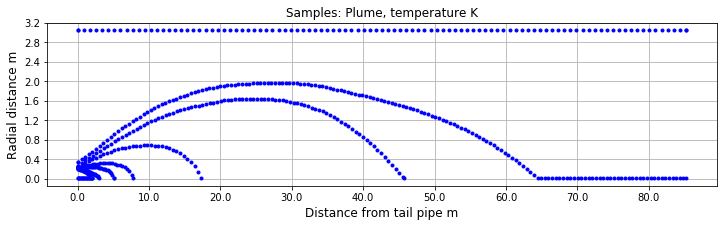

In [5]:
# to plot the sampled temperature iso lines
def plotScatterDataSet(dataset,key, ikey):
    z = dataset[2]
    p = ryplot.Plotter(ikey,1,1,figsize=(12,3));
    p.plot(1,z[:,0], z[:,1],  xlabel='Distance from tail pipe m', ylabel='Radial distance m',
                 ptitle='Samples: {}, temperature K'.format(key),markers=['.'],linestyle='' );

for ikey,key in enumerate(datasets.keys()):
    plotScatterDataSet(datasets[key],key, ikey)

## Interpolate the scanned temperature profiles

The scattered point digitised data sets must now be interpolated and resampled on a regular grid. This is done using the `scipy.interpolate.griddata` function.  To create symmetry in the boundary conditions, the scatter data set is mirrored along both axes. Linear interpolation works the best, cubic interpolation results in too many artefacts (possibly because of the sparse input data). After interpolation only the rear half, behinf the tailpipe, is retained.

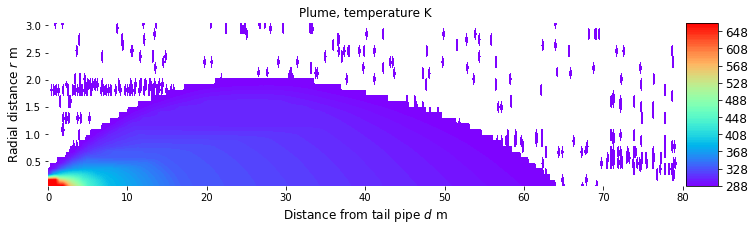

In [6]:
# to interpolate the temperature data to a regular grid
def interpolateDataSet(dataset,key, ikey, numDsamples, numRsamples):
    # get the scatter data set
    z = dataset[2]
    #mirror around the centre line
    zn = z.copy()
    zn[:,1] = -zn[:,1]
    z = np.append(z,zn,axis=0)
    #mirror around the tail pipe
    zn = z.copy()
    zn[:,0] = -zn[:,0]
    z = np.append(z,zn,axis=0)

    #create the regular grid , complex j signifies the number of samples, not step size
    xnew, ynew = np.mgrid[-dataset[1][1]:dataset[1][1]:numDsamples * 1j, -dataset[1][3]:dataset[1][3]:numRsamples * 1j]
    #interpolate
    znew = interpolate.griddata(z[:,0:-1], z[:,-1], (xnew, ynew), method='linear', rescale=True)
    # select only upper-right quadrant, behind tailpipe and above centreline
    select = xnew.__ge__(0) & xnew.__le__(80.) & ynew.__ge__(0)
    #number of selected points along the plume centreline:
    numd = np.sum(select[:, -1])
    #select and reshape back into 2D
    xnew = xnew[select].reshape(numd,-1)
    ynew = ynew[select].reshape(numd,-1)
    znew = znew[select].reshape(numd,-1)

    p = ryplot.Plotter(ikey,1,1,figsize=(12,3));
    p.meshContour(1, xnew, ynew, znew, xlabel='Distance from tail pipe $d$ m', ylabel='Radial distance $r$ m',
                  ptitle='{}, temperature K'.format(key), levels=100, contourLine=False, cbarshow=True);
    # remove the plot frame to not obscure data 
    cp = p.getSubPlot(1)
    cp.spines['top'].set_visible(False)
    cp.spines['right'].set_visible(False)
    cp.spines['bottom'].set_visible(False)
    cp.spines['left'].set_visible(False)

    return xnew, ynew, znew

for ikey,key in enumerate(datasets.keys()):
    resolution = 0.1  # metre
    numd = 2 * np.max(datasets[key][2][:,0]) / resolution
    numr = 2 * np.max(datasets[key][2][:,1]) / resolution
    xnew, ynew, znew = interpolateDataSet(datasets[key],key, ikey, numd, numr)
    datasets[key].append([xnew, ynew, znew])

# at this point the data set dictionary has been appended to, and contains the following:
# datasets[key][0]: list of the input graph lines
# datasets[key][1]: list with the graph domain and range coverage
# datasets[key][2]: single numpy array with _all_ the sampled points (d,r,T) 
# datasets[key][3]: list of arrays with regular grid data [x-mesh-grid, y-mesh-grid, temperature]


At this point the temperatures are available on a fine regular grid as a function of down stream distance and radial displacement from the centre line.  The next step is to convert this to radiance. All imported and calculated data are stored in the `datasets` dictionary, for reuse later.

## Sensor spectral response

The sensor spectral responses are used to support spectral integration. 

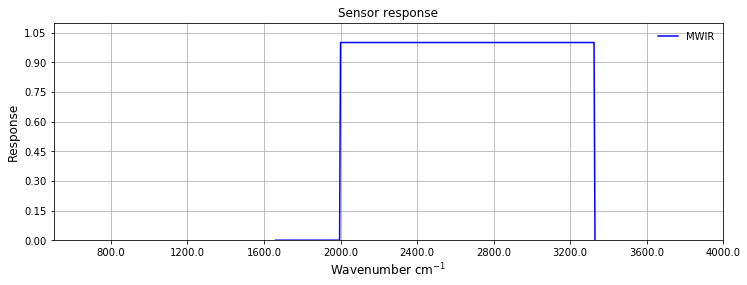

In [7]:
# to load and plot the sensor responses
sensors = ['Unity3_5.txt']
titles = ['MWIR']
q = ryplot.Plotter(1,1,1,figsize=(12,4))
sensorSpcs = {}
for i, (sensor, title) in enumerate(zip(sensors, titles) ):
    sdata = np.loadtxt('data/{}'.format(sensor),comments='%')
    sensorSpcs[sensor] = [sdata]
    wn = sensorSpcs[sensor][0][:,1]
    taus = sensorSpcs[sensor][0][:,2]
    q.plot(1,wn,taus,xlabel='Wavenumber cm$^{-1}$', ylabel='Response', ptitle='Sensor response',
        pltaxis=[500, 4000, 0, 1.1],label=[title],plotCol=[q.plotCol[i]])


## Plume emissivity

In the code used for emissivity calculation, a dictionary of function names is used to calculate the spectral emissivity.  The dictionary uses the spectral band (`NIR`,`SWIR`,`MWIR`,`LWIR`) as key and takes wavenumber and temperature as variables.  The code is implemented and used as shown in the following pseudocode:

    def emisLWIR(wn, temperature=None):
        .....
        return emiss

    def emisMWIR(wn, temperature=None):
        .....
        return emiss

    emisFnLU = {'LWIR': emisLWIR, 'MWIR': emisMWIR}

When a spectral emissivity is required it is calculated as follows:

    wn = np.linspace(...)
    emislw = emisFnLU['LWIR'](wn,300)
    emismw = emisFnLU['MWIR'](wn,300)

Plume temperature is only used in the MWIR calculation and ignored in the other spectral bands.

### MWIR plume spectral emisivity

The plume spectral emissivity is determined as follows:

1.  A measured emissivity near the tail pipe for a jet engine at 800 K is available (red line in the graph below).  This curve shows the pressure and temperature broadened emissivity over a distance of 100 m through the atmosphere.  From this graph two important extreme values for emissivity can be determined: the emissivity at 800 K, given by the outer shape of the curve and the emissivity at near-atmospheric temperatures given by the atmospheric attenuation (the inner shape).
2.  Determine approximate shapes for the 800 K and 300 K gas masses (see the graph below).
3.  Fit a curve to the two extreme emissivity shapes and determine the centre and width of these shapes.
4.  Given the centre and width at the two extremes calculate the emissivity shape by linear interpolation of the centre and width at the required temperature.  The exact law to be used for this interpolation is not known and a simple linear interpolation method is used.
5. Given the temperature-derived centre and width, calculate the emissivity at that tempereture and use for radiance calculation.

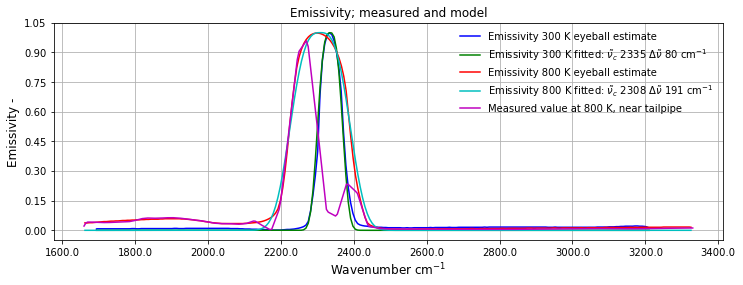

In [8]:
#to digitise emissivity graphs and fit curves to emissivity model

def prepareEmis(dicLines, gscale):
    for i,item in enumerate(dicLines.keys()):

        out = ryutils.extractGraph(item, gscale[0], gscale[1], gscale[2],gscale[3],
            None, False, False, False, step=dicLines[item][0], value=dicLines[item][1] )
        if i==0:
            outA = out
        else:
            outA = np.vstack((outA, out))  
    return outA

emissets = {
    300: [
        {'data/emis-MWIR-300K.png':[10,None]},
        [1600., 3400, 0., 1.0], [2335, 80]
    ],
    800: [
        {'data/emis-MWIR-800K.png':[10,None]},
        [1600., 3400, 0., 1.0],  [2308, 191] 
    ],
}

p = ryplot.Plotter(1,1,1,figsize=(12,4));
for ikey,key in enumerate(emissets.keys()):
    emissets[key].append(prepareEmis(emissets[key][0],emissets[key][1]))
    p.plot(1,emissets[key][3][:,0],emissets[key][3][:,1],label=['Emissivity {} K eyeball estimate'.format(key)]);
    
    emisF =ryutils.sfilter(emissets[key][3][:,0],center=emissets[key][2][0], 
                           width=emissets[key][2][1], exponent=3, taupass=1, taustop=0.)
    p.plot(1,emissets[key][3][:,0],emisF,
           label=[r'Emissivity {} K fitted: $\tilde{{\nu}}_c$ {} $\Delta\tilde{{\nu}}$ {} cm$^{{-1}}$ '.format(key,emissets[key][2][0],emissets[key][2][1] )]);
emis = np.loadtxt('data/emis-800K-MWIR.txt')
p.plot(1, emis[:,1],emis[:,2],'Emissivity; measured and model','Wavenumber cm$^{-1}$',
       'Emissivity -',label=['Measured value at 800 K, near tailpipe'])  ;  



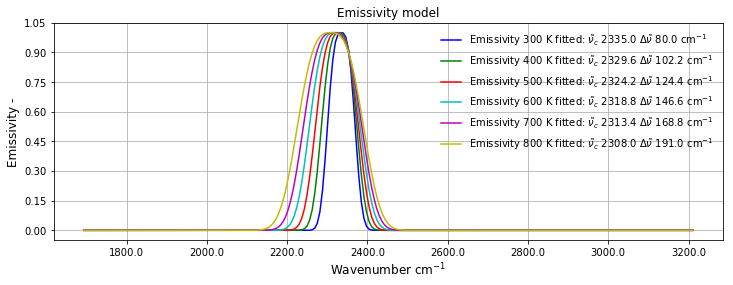

In [9]:
# to calculate spectral emissivity at different temperatures

def emistemp(emissets, wn, temperature):
    wncent = np.interp(temperature, np.asarray([300,800]), np.asarray([emissets[300][2][0],emissets[800][2][0]]))
    wnwid  = np.interp(temperature, np.asarray([300,800]), np.asarray([emissets[300][2][1],emissets[800][2][1]]))
    emisF =ryutils.sfilter(wn,center=wncent,width=wnwid, exponent=3, taupass=1, taustop=0.)
    return emisF, wncent, wnwid

def emisMWIR(wn, temperature):
    emisF,_,_ = emistemp(emissets, wn, temperature)
    return emisF

emisFnLU = {'MWIR': emisMWIR}

wn = emissets[300][3][:,0]

p = ryplot.Plotter(1,1,1,figsize=(12,4));
for temperature in [300, 400, 500, 600, 700, 800]:
    emisF, wncent,wnwid = emistemp(emissets, wn, temperature)
    p.plot(1,wn,emisF,'Emissivity model','Wavenumber cm$^{-1}$','Emissivity -',
           label=[r'Emissivity {} K fitted: $\tilde{{\nu}}_c$ {} $\Delta\tilde{{\nu}}$ {} cm$^{{-1}}$ '.format(temperature,wncent,wnwid )]);
#     emisF = emisFnLU['MWIR'](wn, temperature)
#     p.plot(1,wn,emisF,'Emissivity model','Wavenumber cm$^{-1}$',
#        'Emissivity -',label=[r'Emissivity {} K fitted'.format(temperature)]);


## Plume radiance calculation

\begin{equation}
L_\textrm{plume}(d,r) = \int_{\Delta\lambda}\tau_\textrm{S}\cdot\epsilon_\textrm{plume}(T_\textrm{plume},d,r)\cdot L_\textrm{bb}(T_\textrm{plume},d,r) \textrm{d} \lambda
\end{equation}


At this point we have the sensor response, models for emissivity and the plume spatial temperature distribution.  The spectral integral can now be calculated for each pixel. Observe that the pixel location only provides temperature and that the integral can be simplified into the following steps:

1. Calculate this integral and create a lookup table of temperature to radiance.
\begin{equation}
f_{L_\textrm{plume}}: T_\textrm{plume} \rightarrow \int_{\Delta\lambda}\tau_\textrm{S}\cdot\epsilon_\textrm{plume}(T_\textrm{plume})\cdot L_\textrm{bb}(T_\textrm{plume}) \textrm{d} \lambda
\end{equation}

2. Look up the temperature at location $(d,r)$, and then look up the radiance at this temperature
\begin{equation}
f_{T_\textrm{plume}}: (d,r) \rightarrow T_\textrm{plume}
\end{equation}

\begin{equation}
L_\textrm{plume}(d,r) = f_{L_\textrm{plume}}(f_{T_\textrm{plume}}(d,r) )
\end{equation}


# To be completed ....

## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [11]:
# to get software versions
# https://github.com/rasbt/watermark
# you only need to do this once
# pip install watermark

%load_ext watermark
%watermark -v -m -p numpy,scipy,pyradi -g 

CPython 3.6.1
IPython 5.3.0

numpy 1.12.1
scipy 0.19.0
pyradi 1.1.3

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : c3b80d743fe636f891ac6123908a9228c749c47e
